In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go


#for quick viz
import seaborn as sns

#ml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import random

In [2]:
# verinin okunması 
df = pd.read_excel('train_5.xlsx')


# belirlenen kriterde risk değişkeni oluşturma
def f(df):
    if df['SOKAK_RISK_SKORU'] > df['MAHALLE_RISK_SKORU']:
        val = "Riskli"
    elif df['MAHALLE_RISK_SKORU'] > df['SOB_RISK_SKORU']:
        val = "Riskli"
    elif df['SOKAK_RISK_SKORU'] > df['SOB_RISK_SKORU']:
        val = "Riskli"
    else:
        val = "Düşük Riskli"
    return val

df['Risk_val'] = df.apply(f, axis=1)

fullData_one = df[(df["TESISAT_TIPI"]=="Mesken") & (df["SAYAC_OLCUM_TURU"]=="Aktif") & (df['Risk_val']=="Riskli")]
df_na = fullData_one[(fullData_one.iloc[:,:24].isnull().any(axis=1))].index.to_list()
df['TUKETIM_NAN'] = 0
df.loc[df_na, 'TUKETIM_NAN'] = 1


# bazı kolonların silinmesi
df.drop(['SAYAC_BITIS_TARIHI' ,'SAYAC_MALZEME_ID', 'SAYAC_BASLANGIC_TARIHI'], axis = 1, inplace=True)

# TUKETIM_MX kolonlarındaki NaN değerleri satırların 0 ile doldurulması
zero_tuk_val = df.iloc[:,0:24].columns.to_list()
df[zero_tuk_val] = df[zero_tuk_val].fillna(0)

# DEMAND_MX kolonlarındaki NaN değerleri satırların 0 ile doldurulması
zero_dem_val = df.iloc[:,24:39].columns.to_list()
df[zero_dem_val] = df[zero_dem_val].fillna(0)

# SAYAC_MODEL ve SAYAC_MARKA kolonlarındaki NaN değerlerin MISSING ile doldurulması
df['SAYAC_MODEL'] = df['SAYAC_MODEL'].fillna('MISSING')
df['SAYAC_MARKA'] = df['SAYAC_MARKA'].fillna('MISSING')

# SAYAC_OLCUM_TURU kolonundaki NaN değerlerin Kombi ile doldurulması
df['SAYAC_OLCUM_TURU'] = df['SAYAC_OLCUM_TURU'].fillna('Kombi')

# SAYAC_YAPIM_YILI kolonundaki NaN değerlerin 9999 ile doldurulması
df['SAYAC_YAPIM_YILI'] = df['SAYAC_YAPIM_YILI'].fillna(9999)

# SAYAC_FAZ_N kolonundaki NAN değerlerin TESISAT_TIPI kolonuna göre doldurulması
# TESISAT_TIPI Ticarethane-Sanayi ise Trifaze olarak doldurulur.
# TESISAT_TIPI Mesken ise Monofaze olarak doldurulur.
tic_val = df[(df['TESISAT_TIPI'] == 'Ticarethane-Sanayi')]
tic_val = tic_val[(tic_val['SAYAC_FAZ_N'] != 'Monofaze') & (tic_val['SAYAC_FAZ_N'] != 'Trifaze')]
index_tic_val = tic_val.index.tolist()
df.loc[index_tic_val, 'SAYAC_FAZ_N'] = 'Trifaze'

mes_val = df[(df['TESISAT_TIPI'] == 'Mesken')]
mes_val = mes_val[(mes_val['SAYAC_FAZ_N'] != 'Monofaze') & (mes_val['SAYAC_FAZ_N'] != 'Trifaze')]
index_mes_val = mes_val.index.tolist()
df.loc[index_mes_val, 'SAYAC_FAZ_N'] = 'Monofaze'

# 
df['TESISAT_TIPI'] = df['TESISAT_TIPI'].str.replace('Mesken', '1')
df['TESISAT_TIPI'] = df['TESISAT_TIPI'].str.replace('Ticarethane-Sanayi', '0')
df['TESISAT_TIPI'] = df['TESISAT_TIPI'].astype(int)

df['SAYAC_OLCUM_TURU'] = df['SAYAC_OLCUM_TURU'].str.replace('Aktif', '1')
df['SAYAC_OLCUM_TURU'] = df['SAYAC_OLCUM_TURU'].str.replace('Kombi', '0')
df['SAYAC_OLCUM_TURU'] = df['SAYAC_OLCUM_TURU'].astype(int)

df['SAYAC_FAZ_N'] = df['SAYAC_FAZ_N'].str.replace('Monofaze', '1')
df['SAYAC_FAZ_N'] = df['SAYAC_FAZ_N'].str.replace('Trifaze', '0')
df['SAYAC_FAZ_N'] = df['SAYAC_FAZ_N'].astype(int)

# SAYAC_MARKA gruplaması
for i in range(len(df['SAYAC_MARKA'])):    

    if (df['SAYAC_MARKA'][i] == 'KAAN') | (df['SAYAC_MARKA'][i] == 'MAKEL') | (df['SAYAC_MARKA'][i] == 'KOHLER'):
        df.loc[i, 'SAYAC_MARKA'] = 'KAAN-MAKEL-KOHLER'
    elif (df['SAYAC_MARKA'][i] == 'ELEKTROMED') | (df['SAYAC_MARKA'][i] == 'VI-KO') :
        df.loc[i, 'SAYAC_MARKA'] = 'ELEKTROMED-VI-KO'
    elif (df['SAYAC_MARKA'][i] == 'DMA') | (df['SAYAC_MARKA'][i] == 'NORA'):
        df.loc[i, 'SAYAC_MARKA'] = 'DMA-NORA'

# SAYAC_MODEL gruplaması
for i in range(len(df['SAYAC_MODEL'])):    

    if (df['SAYAC_MODEL'][i] == 'EC25TPA3CHB') | (df['SAYAC_MODEL'][i] == 'AEL.TF.16-2') | (df['SAYAC_MODEL'][i] == 'AEL.MF.11') | (df['SAYAC_MODEL'][i] == 'LSM-35 HBR') | (df['SAYAC_MODEL'][i] == 'LSM35-KM') | (df['SAYAC_MODEL'][i] == 'LUN23 TF') | (df['SAYAC_MODEL'][i] == 'LUN10-B') | (df['SAYAC_MODEL'][i] == 'M560.2251S') | (df['SAYAC_MODEL'][i] == 'M600.2251') | (df['SAYAC_MODEL'][i] == 'LUN10 HBR'):
        df.loc[i, 'SAYAC_MODEL'] = 'GROUP-1'                                                  
    elif (df['SAYAC_MODEL'][i] == 'EC058MCT')  | (df['SAYAC_MODEL'][i] == 'LSM-35') | (df['SAYAC_MODEL'][i] == 'LUN10') | (df['SAYAC_MODEL'][i] == 'M500.2211') | (df['SAYAC_MODEL'][i] == 'VEM-M580DB0E') | (df['SAYAC_MODEL'][i] == 'VEM-T5100DB2') | (df['SAYAC_MODEL'][i] == 'T510.2251') | (df['SAYAC_MODEL'][i] == 'VEM-T5100DB0E'):
          df.loc[i, 'SAYAC_MODEL'] = 'GROUP-2'                                                  
    elif (df['SAYAC_MODEL'][i] == 'AEL.MF.07')  | (df['SAYAC_MODEL'][i] == 'DA 1118') | (df['SAYAC_MODEL'][i] == 'EC058MBW') | (df['SAYAC_MODEL'][i] == 'LUN21') | (df['SAYAC_MODEL'][i] == 'M500.2251') | (df['SAYAC_MODEL'][i] == 'VEM-M580DB0') | (df['SAYAC_MODEL'][i] == 'VEM-T5100DB0'):
          df.loc[i, 'SAYAC_MODEL'] = 'GROUP-3'                                                   
    elif (df['SAYAC_MODEL'][i] == 'AEL.TF.16') | (df['SAYAC_MODEL'][i] == 'EC018MBW') | (df['SAYAC_MODEL'][i] == 'LUN1') | (df['SAYAC_MODEL'][i] == 'M310.2218'):
          df.loc[i, 'SAYAC_MODEL'] = 'GROUP-4'                                                  
    elif (df['SAYAC_MODEL'][i] == 'EC15ATBW') | (df['SAYAC_MODEL'][i] == 'EC11ATBW'):
          df.loc[i, 'SAYAC_MODEL'] = 'GROUP-5'                                                   
    elif (df['SAYAC_MODEL'][i] == 'M550.2251'):
          df.loc[i, 'SAYAC_MODEL'] = 'GROUP-6'    
    else:
        df.loc[i, 'SAYAC_MODEL'] = 'OTHER'
                                                   

# yeni kolon : 'SAYAC_YAS'
df['SAYAC_YAS'] = (df['SAYAC_TAKILMA_TARIHI'].dt.year)-df['SAYAC_YAPIM_YILI']
df["SAYAC_YAS"] = df["SAYAC_YAS"].fillna(0)

# SAYAC_YAS gruplaması
for i in range(len(df['SAYAC_YAS'])):    

    if (df['SAYAC_YAS'][i] == 4.0) | (df['SAYAC_YAS'][i] == 5.0) | (df['SAYAC_YAS'][i] == 6.0):
        df.loc[i, 'SAYAC_YAS'] = 'GROUP-1'
    elif (df['SAYAC_YAS'][i] == 0.0) | (df['SAYAC_YAS'][i] == 1.0) :
        df.loc[i, 'SAYAC_YAS'] = 'GROUP-2'
    elif (df['SAYAC_YAS'][i] == 7.0) | (df['SAYAC_YAS'][i] == 8.0) | (df['SAYAC_YAS'][i] == 9.0):
        df.loc[i, 'SAYAC_YAS'] = 'GROUP-3'
    elif (df['SAYAC_YAS'][i] == 2.0):
        df.loc[i, 'SAYAC_YAS'] = 'GROUP-5'
    elif (df['SAYAC_YAS'][i] == 3.0):
        df.loc[i, 'SAYAC_YAS'] = 'GROUP-6'
    else:
        df.loc[i, 'SAYAC_YAS'] = 'OTHER'        
        
# SAYAC_YAPIM_YILI gruplaması
for i in range(len(df['SAYAC_YAPIM_YILI'])):    

    if (df['SAYAC_YAPIM_YILI'][i] == 2007.0) | (df['SAYAC_YAPIM_YILI'][i] == 2008.0) | (df['SAYAC_YAPIM_YILI'][i] == 2009.0):
        df.loc[i, 'SAYAC_YAPIM_YILI'] = 'GROUP-1'
    elif (df['SAYAC_YAPIM_YILI'][i] == 2010.0) | (df['SAYAC_YAPIM_YILI'][i] == 2011.0) | (df['SAYAC_YAPIM_YILI'][i] == 2012.0):
        df.loc[i, 'SAYAC_YAPIM_YILI'] = 'GROUP-2'
    elif (df['SAYAC_YAPIM_YILI'][i] == 2013.0) | (df['SAYAC_YAPIM_YILI'][i] == 2014.0):
        df.loc[i, 'SAYAC_YAPIM_YILI'] = 'GROUP-3'
    elif (df['SAYAC_YAPIM_YILI'][i] == 2015.0) | (df['SAYAC_YAPIM_YILI'][i] == 2016.0):
        df.loc[i, 'SAYAC_YAPIM_YILI'] = 'GROUP-4'
    elif (df['SAYAC_YAPIM_YILI'][i] == 2017.0) | (df['SAYAC_YAPIM_YILI'][i] == 2018.0) | (df['SAYAC_YAPIM_YILI'][i] == 2019.0) | (df['SAYAC_YAPIM_YILI'][i] == 2020.0):
        df.loc[i, 'SAYAC_YAPIM_YILI'] = 'GROUP-5'
    else:
        df.loc[i, 'SAYAC_YAPIM_YILI'] = 'OTHER'  
             
# yeni kolon : 'RISK_VE_OLCUM'
risk_and_msrt = df[(df['SOKAK_RISK_SKORU'] > df['MAHALLE_RISK_SKORU']) & (df['SAYAC_OLCUM_TURU'] == 'Kombi')]
index_risk_msrt = risk_and_msrt.index.tolist()
df['RISK_VE_OLCUM'] = 0
df.loc[index_risk_msrt, 'RISK_VE_OLCUM'] = 1
    
# yeni kolon : 'TUKETIM_OUTLIER'
index = []
for i in range(df.shape[0]):
    for j in range(24):
        Q1 = np.quantile(df.iloc[:,j], 0.25)
        Q3 = np.quantile(df.iloc[:,j], 0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5*IQR
        upper_bound = Q3 + 1.5*IQR
        if ((df.iloc[i,j] < lower_bound) | (df.iloc[i,j] > upper_bound)):
            index.append(i)
outliers = set(index)
tuketim_outlier = df.loc[outliers, :]
index_outlier = tuketim_outlier.index.to_list()
df['TUKETIM_OUTLIER'] = 0
df.loc[index_outlier, 'TUKETIM_OUTLIER'] = 1


C:\ProgramData\Anaconda3\envs\jupyterlab\lib\site-packages\pandas\core\computation\expressions.py:68: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return op(a, b)


In [3]:
flag_one = df[df['NK_FLAG'] == 1]
flag_two = df[df['NK_FLAG'] == 0]

flag_one = flag_one.iloc[90:300,:]
flag_two = flag_two.iloc[600:3390,:]
frames = [flag_one, flag_two]
valData = pd.concat(frames)
index_val = valData.index.to_list()
train_testData = df.drop(index_val)

In [4]:
valData.drop(['SAYAC_TAKILMA_TARIHI'], axis = 1, inplace=True)
train_testData.drop(['SAYAC_TAKILMA_TARIHI'], axis = 1, inplace=True)

valData = df.sort_values(by='SAYAC_BASLANGIC_TARIHI',ascending=False).head(3000)
train_testData = df.sort_values(by='SAYAC_BASLANGIC_TARIHI',ascending=False).tail(12000)

In [5]:
for col in train_testData.columns:
        print(str(col) +" : " + str(train_testData[col].nunique()))

TUKETIM_M1 : 11355
TUKETIM_M2 : 11471
TUKETIM_M3 : 11516
TUKETIM_M4 : 11514
TUKETIM_M5 : 11584
TUKETIM_M6 : 11589
TUKETIM_M7 : 11627
TUKETIM_M8 : 11608
TUKETIM_M9 : 11600
TUKETIM_M10 : 11572
TUKETIM_M11 : 11570
TUKETIM_M12 : 11516
TUKETIM_M13 : 11513
TUKETIM_M14 : 11421
TUKETIM_M15 : 11416
TUKETIM_M16 : 11358
TUKETIM_M17 : 11385
TUKETIM_M18 : 11378
TUKETIM_M19 : 11391
TUKETIM_M20 : 11303
TUKETIM_M21 : 11264
TUKETIM_M22 : 11222
TUKETIM_M23 : 11180
TUKETIM_M24 : 11068
DEMAND_M1 : 2786
DEMAND_M2 : 2717
DEMAND_M3 : 2838
DEMAND_M4 : 2602
DEMAND_M5 : 2501
DEMAND_M6 : 2147
DEMAND_M7 : 2260
DEMAND_M8 : 2152
DEMAND_M9 : 2243
DEMAND_M10 : 2224
DEMAND_M11 : 2463
DEMAND_M12 : 2510
SOB_RISK_SKORU : 2727
SOKAK_RISK_SKORU : 1268
MAHALLE_RISK_SKORU : 1371
TESISAT_TIPI : 2
SAYAC_MARKA : 6
SAYAC_MODEL : 7
SAYAC_OLCUM_TURU : 2
SAYAC_FAZ_N : 2
SAYAC_YAPIM_YILI : 6
NK_FLAG : 2
Risk_val : 2
TUKETIM_NAN : 2
SAYAC_YAS : 5
RISK_VE_OLCUM : 1
TUKETIM_OUTLIER : 2


In [6]:
for col in valData.columns:
        print(str(col) +" : " + str(valData[col].nunique()))

TUKETIM_M1 : 2820
TUKETIM_M2 : 2847
TUKETIM_M3 : 2865
TUKETIM_M4 : 2871
TUKETIM_M5 : 2892
TUKETIM_M6 : 2886
TUKETIM_M7 : 2897
TUKETIM_M8 : 2882
TUKETIM_M9 : 2883
TUKETIM_M10 : 2883
TUKETIM_M11 : 2888
TUKETIM_M12 : 2870
TUKETIM_M13 : 2873
TUKETIM_M14 : 2847
TUKETIM_M15 : 2855
TUKETIM_M16 : 2846
TUKETIM_M17 : 2840
TUKETIM_M18 : 2842
TUKETIM_M19 : 2850
TUKETIM_M20 : 2831
TUKETIM_M21 : 2832
TUKETIM_M22 : 2813
TUKETIM_M23 : 2797
TUKETIM_M24 : 2764
DEMAND_M1 : 1470
DEMAND_M2 : 1445
DEMAND_M3 : 1534
DEMAND_M4 : 1376
DEMAND_M5 : 1347
DEMAND_M6 : 1148
DEMAND_M7 : 1273
DEMAND_M8 : 1196
DEMAND_M9 : 1255
DEMAND_M10 : 1196
DEMAND_M11 : 1311
DEMAND_M12 : 1288
SOB_RISK_SKORU : 1503
SOKAK_RISK_SKORU : 650
MAHALLE_RISK_SKORU : 950
TESISAT_TIPI : 2
SAYAC_MARKA : 6
SAYAC_MODEL : 7
SAYAC_OLCUM_TURU : 2
SAYAC_FAZ_N : 2
SAYAC_YAPIM_YILI : 6
NK_FLAG : 2
Risk_val : 2
TUKETIM_NAN : 2
SAYAC_YAS : 5
RISK_VE_OLCUM : 1
TUKETIM_OUTLIER : 2


## TRAIN TEST DATA ONE-HOT-ENCODING

In [7]:
cat_cols = ['SAYAC_MARKA','SAYAC_MODEL','SAYAC_YAPIM_YILI','SAYAC_YAS']
for col in cat_cols:
   train_testData[col] = train_testData[col].astype('object')

columns_to_encode = []
for col in train_testData.columns:
  if train_testData[col].dtype == 'object':
    columns_to_encode.append(col)

oneHotEncoded_train_testData = pd.get_dummies(train_testData, columns = columns_to_encode)

In [8]:
features = []
for col in oneHotEncoded_train_testData.columns:
  if col != 'NK_FLAG':
    features.append(col)

# Target - bağımlı değişken
target = 'NK_FLAG'

X = oneHotEncoded_train_testData[features]  # bağımsız değişkenler
y = oneHotEncoded_train_testData[target]  # target değişken

In [9]:
oneHotEncoded_train_testData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 14999
Data columns (total 72 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   TUKETIM_M1                     12000 non-null  float64
 1   TUKETIM_M2                     12000 non-null  float64
 2   TUKETIM_M3                     12000 non-null  float64
 3   TUKETIM_M4                     12000 non-null  float64
 4   TUKETIM_M5                     12000 non-null  float64
 5   TUKETIM_M6                     12000 non-null  float64
 6   TUKETIM_M7                     12000 non-null  float64
 7   TUKETIM_M8                     12000 non-null  float64
 8   TUKETIM_M9                     12000 non-null  float64
 9   TUKETIM_M10                    12000 non-null  float64
 10  TUKETIM_M11                    12000 non-null  float64
 11  TUKETIM_M12                    12000 non-null  float64
 12  TUKETIM_M13                    12000 non-null 

In [10]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

C:\ProgramData\Anaconda3\envs\jupyterlab\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='NK_FLAG', ylabel='count'>

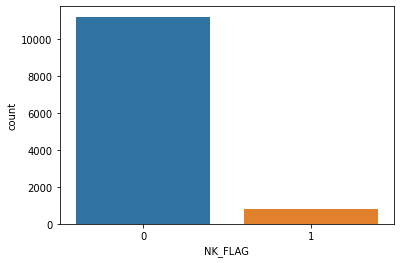

In [11]:
chck = pd.DataFrame()
chck['NK_FLAG'] = y

sns.countplot(chck['NK_FLAG'])

## IMBALANCE DATASETTE TRAIN_TEST SPLIT UYGULARKEN OVERSAMPLING YÖNTEMİ

In [12]:
oversample = SMOTE(random_state=9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y,  random_state = 42)
X_over, y_over = oversample.fit_resample(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, random_state = 1)

C:\ProgramData\Anaconda3\envs\jupyterlab\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='NK_FLAG', ylabel='count'>

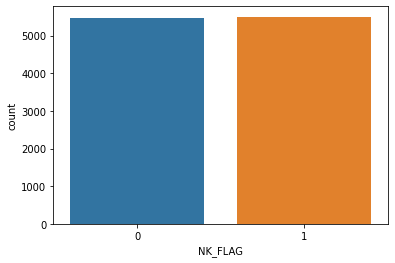

In [13]:
chck = pd.DataFrame()
chck['NK_FLAG'] = y_train

sns.countplot(chck['NK_FLAG'])

In [14]:
from catboost import CatBoostClassifier

In [15]:
import pickle
model = CatBoostClassifier()
model.fit(X_train, y_train)
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

Learning rate set to 0.028644
0:	learn: 0.6596361	total: 185ms	remaining: 3m 5s
1:	learn: 0.6281731	total: 197ms	remaining: 1m 38s
2:	learn: 0.5999016	total: 208ms	remaining: 1m 9s
3:	learn: 0.5737137	total: 218ms	remaining: 54.2s
4:	learn: 0.5531089	total: 228ms	remaining: 45.4s
5:	learn: 0.5320510	total: 238ms	remaining: 39.5s
6:	learn: 0.5119670	total: 249ms	remaining: 35.3s
7:	learn: 0.4906271	total: 259ms	remaining: 32.1s
8:	learn: 0.4693159	total: 268ms	remaining: 29.5s
9:	learn: 0.4523842	total: 278ms	remaining: 27.5s
10:	learn: 0.4359017	total: 288ms	remaining: 25.9s
11:	learn: 0.4233437	total: 297ms	remaining: 24.5s
12:	learn: 0.4107597	total: 307ms	remaining: 23.3s
13:	learn: 0.3971964	total: 317ms	remaining: 22.3s
14:	learn: 0.3857488	total: 326ms	remaining: 21.4s
15:	learn: 0.3776515	total: 336ms	remaining: 20.7s
16:	learn: 0.3676963	total: 346ms	remaining: 20s
17:	learn: 0.3594236	total: 355ms	remaining: 19.4s
18:	learn: 0.3524562	total: 365ms	remaining: 18.8s
19:	learn: 0

In [16]:
asdfg

NameError: name 'asdfg' is not defined

In [ ]:
rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)

preds = rfc.predict(X_test)

score = rfc.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

## VALIDATION DATA ONE-HOT-ENCODING

In [ ]:
cat_cols1 = ['SAYAC_MARKA','SAYAC_MODEL','SAYAC_YAPIM_YILI','SAYAC_YAS']
for col in cat_cols1:
  valData[col] = valData[col].astype('object')

columns_to_encode1 = []
for col in valData.columns:
  if valData[col].dtype == 'object':
    columns_to_encode1.append(col)

oneHotEncoded_valData = pd.get_dummies(valData, columns = columns_to_encode1)

In [ ]:
features1 = []
for col in oneHotEncoded_valData.columns:
  if col != 'NK_FLAG':
    features1.append(col)

target1 = 'NK_FLAG'

X_val = oneHotEncoded_valData[features1]
y_val = oneHotEncoded_valData[target1]

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_val = sc.fit_transform(X_val)

In [ ]:
preds = rfc.predict(X_val)
score = rfc.score(X_val, y_val)
print(score*100)
print()
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

In [ ]:
rfc2 = RandomForestClassifier(random_state = 1)
rfc2.fit(X_train, y_train)

preds = rfc2.predict(X_val)
score = rfc2.score(X_val, y_val)

threshold = 0.34

preds = rfc2.predict_proba(X_val)
preds = (preds[:,1] >= threshold).astype('int')
print(score*100)
print()
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

In [ ]:
dtc = DecisionTreeClassifier()

dtc.fit(X_train, y_train)
preds = dtc.predict(X_val)

preds = dtc.predict(X_val)
threshold = 0.4

preds = dtc.predict_proba(X_val)
preds = (preds[:,1] >= threshold).astype('int')

score = dtc.score(X_val, y_val)
print(score)
print()
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

In [ ]:
svc = SVC(kernel='linear',probability=True, random_state=3)
svc.fit(X_train, y_train)

preds = svc.predict(X_val)
threshold = 0.34

preds = svc.predict_proba(X_val)
preds = (preds[:,1] >= threshold).astype('int')

print('Score:' , svc.score(X_val, y_val))
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

In [ ]:
svc = SVC(kernel='rbf',probability=True, random_state=3)
svc.fit(X_train, y_train)

preds = svc.predict(X_val)
threshold = 0.81
preds = svc.predict_proba(X_val)
preds = (preds[:,1] >= threshold).astype('int')

print('Score:' , svc.score(X_val, y_val))
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

In [ ]:
# !pip install CatBoost

In [ ]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(max_depth=5, n_estimators=200)

cat.fit(X_train, y_train)
preds = cat.predict(X_test)
score = cat.score(X_test, y_test)

print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True, fmt='g')

In [ ]:
preds = cat.predict(X_val)
score = cat.score(X_val, y_val)

threshold = 0.75
predicted_proba = (cat.predict_proba(X_val)[:,1] >= threshold).astype("int")

print(score*100)
print()
print(classification_report(y_val, predicted_proba))

cm = confusion_matrix(y_val, predicted_proba)
sns
sns.heatmap(cm, annot=True, fmt='g')